## LDA with Hyperparameter Tuning

**Tuning LDA:** https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [1]:
import sys
print(sys.version)

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


In [2]:
#!pip install gensim --upgrade

In [3]:
import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [4]:
import warnings

# warnings.simplefilter('once')
warnings.simplefilter('ignore')
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [5]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 7 workers


#### Copy files to local FS from GCP bucket

In [6]:
path_news = '/home/jupyter/data/news'
path_tweets = '/home/jupyter/data/tweets'
path_lda = '/home/jupyter/data/lda'

if not os.path.isdir(path_news): os.mkdir(path_news)
if not os.path.isdir(path_tweets): os.mkdir(path_tweets)
if not os.path.isdir(path_lda): os.mkdir(path_lda)

In [7]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

## Applying LDA to news articles

In [8]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/news_toyota.json'

news_df = pd.read_json(news_path, orient='records', lines=True)
news_df.shape

(100, 4)

In [9]:
news_df.head(5)

,crawled,language,text,title
0,2018-02-02T04:24:51.072+02:00,english,QR Code Link to This Post All maintenance rece...,Dependable truck 03 Toyota Tacoma Double Cab $...
1,2018-02-02T04:27:15.000+02:00,english,0 \nNEW YORK: Automakers reported mixed US car...,US car sales mixed in January; trucks stay strong
2,2018-02-02T04:34:00.008+02:00,english,transmission: automatic 2005 Toyota Camry LE...,2005 TOYOTA CAMRY LE 167300 MILEAGE $2450 (TAL...
3,2018-02-02T04:36:42.006+02:00,english,favorite this post Brand New Toyota Avalon Flo...,Brand New Toyota Avalon Floor Mats (New Britai...
4,2018-02-02T04:38:24.018+02:00,english,more ads by this user QR Code Link to This Pos...,2016 Lexus ES 350 (Coliseum Lexus of Oakland) ...


## Clean text

In [10]:
# Filter non-English articles
%time news_eng = news_df[news_df['language']=='english'].reset_index(drop=True)

CPU times: user 1.18 ms, sys: 0 ns, total: 1.18 ms
Wall time: 1.04 ms


#### Tokenize text into words and remove punctuation

In [11]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = news_eng['text'].tolist()        
data_tokens = list(sent_to_words(data_list))

CPU times: user 186 ms, sys: 863 µs, total: 187 ms
Wall time: 203 ms


#### Remove Stopwords, Make n-grams and Lemmatize

In [12]:
%%time

# bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 343 ms, sys: 5.12 ms, total: 348 ms
Wall time: 346 ms


In [13]:
%%time

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 755 µs, sys: 3.83 ms, total: 4.59 ms
Wall time: 3.07 ms


In [14]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized[:1])

['maintenance', 'receipt', 'available', 'one_owner', 'truck', 'cash', 'sale', 'trade']
CPU times: user 3.81 s, sys: 72 ms, total: 3.88 s
Wall time: 3.88 s


In [15]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

CPU times: user 42.9 ms, sys: 741 µs, total: 43.6 ms
Wall time: 41.4 ms


#### Build initial 3 topic model

In [16]:
%%time

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=3,
                   random_state=100,
                   passes=10,
                   alpha='symmetric',
                   eta='auto',
                   workers=workers)

CPU times: user 1.63 s, sys: 246 ms, total: 1.88 s
Wall time: 1.93 s


In [17]:
# Print the Keyword in the 3 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]

[(0,
  '0.007*"company" + 0.007*"say" + 0.006*"percent" + 0.005*"year" + '
  '0.005*"job" + 0.005*"see" + 0.005*"make" + 0.004*"per_cent" + 0.004*"state" '
  '+ 0.004*"sale"'),
 (1,
  '0.009*"car" + 0.008*"vehicle" + 0.005*"also" + 0.005*"say" + 0.005*"make" + '
  '0.005*"include" + 0.004*"new" + 0.004*"year" + 0.004*"model" + '
  '0.004*"contact"'),
 (2,
  '0.028*"percent" + 0.008*"cent" + 0.007*"year" + 0.007*"rise" + '
  '0.007*"per_barrel" + 0.007*"yen" + 0.007*"gain" + 0.006*"unit" + '
  '0.006*"report" + 0.006*"growth"')]


#### Compute Coherence Score

In [18]:
%%time

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.466116080951055
CPU times: user 222 ms, sys: 147 ms, total: 369 ms
Wall time: 535 ms


#### Tune LDA model

In [19]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

#### Hyperparameter Tuning:
- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

In [20]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)
lda_tuning.to_csv(os.path.join(path_lda, 'lda_tuning_results.csv'), index=False)

LDA will execute 19 iterations
Completed model based on 2 LDA topics. Finished 5.3% of LDA runs
Execution time to calculate for topic 2: 0hour:0min:2sec
Completed model based on 3 LDA topics. Finished 10.5% of LDA runs
Execution time to calculate for topic 3: 0hour:0min:2sec
Completed model based on 4 LDA topics. Finished 15.8% of LDA runs
Execution time to calculate for topic 4: 0hour:0min:2sec
Completed model based on 5 LDA topics. Finished 21.1% of LDA runs
Execution time to calculate for topic 5: 0hour:0min:2sec
Completed model based on 6 LDA topics. Finished 26.3% of LDA runs
Execution time to calculate for topic 6: 0hour:0min:2sec
Completed model based on 7 LDA topics. Finished 31.6% of LDA runs
Execution time to calculate for topic 7: 0hour:0min:3sec
Completed model based on 8 LDA topics. Finished 36.8% of LDA runs
Execution time to calculate for topic 8: 0hour:0min:3sec
Completed model based on 9 LDA topics. Finished 42.1% of LDA runs
Execution time to calculate for topic 9: 0h

In [21]:
lda_tuning = pd.read_csv(os.path.join(path_lda, 'lda_tuning_results.csv'))

#### Coherence scores are extremely close for all models

In [22]:
# Best LDA parameters
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
0,2,asymmetric,auto,0.566302
1,3,asymmetric,auto,0.535703
2,4,asymmetric,auto,0.511686
12,14,asymmetric,auto,0.488498
10,12,asymmetric,auto,0.484938
17,19,asymmetric,auto,0.479144
6,8,asymmetric,auto,0.476321
14,16,asymmetric,auto,0.474955
3,5,asymmetric,auto,0.471551
16,18,asymmetric,auto,0.463996


In [23]:
# Worst LDA parameters
lda_tuning.sort_values(by=['Coherence']).head(10)

,Topics,Alpha,Beta,Coherence
5,7,asymmetric,auto,0.395257
9,11,asymmetric,auto,0.402453
11,13,asymmetric,auto,0.416051
18,20,asymmetric,auto,0.442641
8,10,asymmetric,auto,0.443701
7,9,asymmetric,auto,0.445376
4,6,asymmetric,auto,0.445981
13,15,asymmetric,auto,0.446784
15,17,asymmetric,auto,0.455121
16,18,asymmetric,auto,0.463996


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

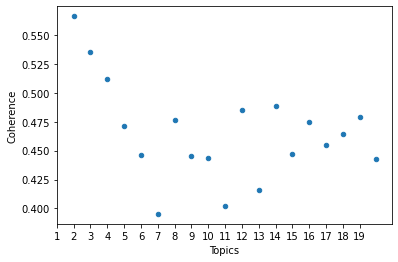

In [24]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'scatter', xticks=range(1,20))

<AxesSubplot:xlabel='Topics'>

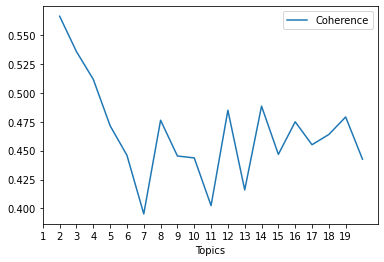

In [25]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(1,20))

#### Running best model

In [26]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 2, Alpha: asymmetric, Beta: auto


In [27]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.466116080951055
CPU times: user 1.75 s, sys: 225 ms, total: 1.97 s
Wall time: 2.01 s


In [28]:
%%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

CPU times: user 276 ms, sys: 215 ms, total: 492 ms
Wall time: 1.93 s


In [29]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Sat, 29 October 2022 15:43:39'